# **SONG CLUSTERING**

Maria Giustiniano \
Simone Quadrelli 

![](https://drive.google.com/uc?id=1M3QI2x97MWZ2MfJhkk29yIq68LBmeXuB)



Algorithms for massive datasets \\
Academic year 2019/2020


##Set up Spark


In [0]:
sudo apt update
gcloud compute ssh --zone us-central1-a instance2 --ssh-flag="-L 8888:localhost:8888"
sudo apt install python3-pip python3-dev
sudo -H pip3 install --upgrade pip
pip install jupyter
https://www.digitalocean.com/community/tutorials/how-to-set-up-jupyter-notebook-with-python-3-on-ubuntu-18-04

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-redshift_2.10:2.0.1 pyspark-shell'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"


import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

## Install libraries

In [0]:
!pip install librosa
!pip install kaggle --upgrade
#!pip install ffmpeg

# Download data





In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
! chmod 600 ./kaggle.json

In [0]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

## Unzip data


In [0]:
!unzip gtzan-dataset-music-genre-classification.zip

## Remove 54th jazz song since the file is corrupted

In [0]:
rm Data/genres_original/jazz/jazz.00054.wav

rm: cannot remove 'Data/genres_original/jazz/jazz.00054.wav': No such file or directory


## Feature extraction

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import statistics 
import plotly.express as px
from pathlib import Path
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA

In [0]:
paths = [str(path) for path in Path('Data/genres_original').rglob('*.wav')]   

In [0]:
FEATURES_COL = ['spectral_flatness_mean', 'spectral_flatness_var',
       'chroma_stft_mean', 'chroma_stft_var', 'spectral_centroid_mean',
       'spectral_centroid_var', 'spectral_bandwidth_mean',
       'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var',
       'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'root_mean_square_mean', 'root_mean_square_var',
       'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean',
       'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean',
       'mfcc17_mean', 'mfcc18_mean', 'mfcc19_mean', 'mfcc20_mean',
       'mfcc1_var', 'mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var',
       'mfcc6_var', 'mfcc7_var', 'mfcc8_var', 'mfcc9_var', 'mfcc10_var',
       'mfcc11_var', 'mfcc12_var', 'mfcc13_var', 'mfcc14_var',
       'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_varn',
       'mfcc19_var', 'mfcc20_var']

#Da non utilizzare



In [0]:
'''
def feature_extraction(path):
    x, sr = librosa.load(path)
    flat = librosa.feature.spectral_flatness(x)
    chroma_stft = librosa.feature.chroma_stft(x,sr)
    spec_cent = librosa.feature.spectral_centroid(x,sr)
    spec_bw = librosa.feature.spectral_bandwidth(x,sr)
    rolloff = librosa.feature.spectral_rolloff(x,sr)
    zcr = librosa.feature.zero_crossing_rate(x)
    mfcc = librosa.feature.mfcc(x,sr)
    S, phase = librosa.magphase(librosa.stft(x))
    rms = librosa.feature.rms(S) 
    y, sr = librosa.load(path)
    onset_env = librosa.onset.onset_strength(x, sr)
    tempo = librosa.beat.tempo(onset_env,sr)
    pos = [m.start() for m in re.finditer('/', path)]
    return (Vectors.dense([np.mean(flat).tolist(),np.var(flat).tolist(),
                            np.mean(chroma_stft).tolist(),np.var(chroma_stft).tolist(),
                            np.mean(spec_cent).tolist(), np.var(spec_cent).tolist(),
                            np.mean(spec_bw).tolist(),np.var(spec_bw).tolist(),
                            np.mean(rolloff).tolist(),np.var(rolloff).tolist(),
                            np.mean(zcr).tolist(),np.var(zcr).tolist(),
                            np.mean(rms).tolist(),np.var(rms).tolist(),
                            tempo[0].item() ] + mfcc.mean(axis = 1).tolist() + mfcc.var(axis = 1).tolist()))
'''

"\ndef feature_extraction(path):\n    x, sr = librosa.load(path)\n    flat = librosa.feature.spectral_flatness(x)\n    chroma_stft = librosa.feature.chroma_stft(x,sr)\n    spec_cent = librosa.feature.spectral_centroid(x,sr)\n    spec_bw = librosa.feature.spectral_bandwidth(x,sr)\n    rolloff = librosa.feature.spectral_rolloff(x,sr)\n    zcr = librosa.feature.zero_crossing_rate(x)\n    mfcc = librosa.feature.mfcc(x,sr)\n    S, phase = librosa.magphase(librosa.stft(x))\n    rms = librosa.feature.rms(S) \n    y, sr = librosa.load(path)\n    onset_env = librosa.onset.onset_strength(x, sr)\n    tempo = librosa.beat.tempo(onset_env,sr)\n    pos = [m.start() for m in re.finditer('/', path)]\n    return (Vectors.dense([np.mean(flat).tolist(),np.var(flat).tolist(),\n                            np.mean(chroma_stft).tolist(),np.var(chroma_stft).tolist(),\n                            np.mean(spec_cent).tolist(), np.var(spec_cent).tolist(),\n                            np.mean(spec_bw).tolist(),np.

In [0]:
'''
def test_feature_extraction(path):
    x, sr = librosa.load(path)
    flat = librosa.feature.spectral_flatness(x)
    chroma_stft = librosa.feature.chroma_stft(x,sr)
    spec_cent = librosa.feature.spectral_centroid(x,sr)
    spec_bw = librosa.feature.spectral_bandwidth(x,sr)
    rolloff = librosa.feature.spectral_rolloff(x,sr)
    zcr = librosa.feature.zero_crossing_rate(x)
    mfcc = librosa.feature.mfcc(x,sr)
    S, phase = librosa.magphase(librosa.stft(x))
    rms = librosa.feature.rms(S)
    y, sr = librosa.load(path)
    onset_env = librosa.onset.onset_strength(x, sr)
    tempo = librosa.beat.tempo(onset_env,sr)
    pos = [m.start() for m in re.finditer('/', path)]
    return [np.mean(flat).tolist(),np.var(flat).tolist(),
                            np.mean(chroma_stft).tolist(),np.var(chroma_stft).tolist(),
                            np.mean(spec_cent).tolist(), np.var(spec_cent).tolist(),
                            np.mean(spec_bw).tolist(),np.var(spec_bw).tolist(),
                            np.mean(rolloff).tolist(),np.var(rolloff).tolist(),
                            np.mean(zcr).tolist(),np.var(zcr).tolist(),
                            np.mean(rms).tolist(),np.var(rms).tolist()
                            ] + mfcc.mean(axis = 1).tolist() + mfcc.var(axis = 1).tolist()
'''

"\ndef test_feature_extraction(path):\n    x, sr = librosa.load(path)\n    flat = librosa.feature.spectral_flatness(x)\n    chroma_stft = librosa.feature.chroma_stft(x,sr)\n    spec_cent = librosa.feature.spectral_centroid(x,sr)\n    spec_bw = librosa.feature.spectral_bandwidth(x,sr)\n    rolloff = librosa.feature.spectral_rolloff(x,sr)\n    zcr = librosa.feature.zero_crossing_rate(x)\n    mfcc = librosa.feature.mfcc(x,sr)\n    S, phase = librosa.magphase(librosa.stft(x))\n    rms = librosa.feature.rms(S)\n    y, sr = librosa.load(path)\n    onset_env = librosa.onset.onset_strength(x, sr)\n    tempo = librosa.beat.tempo(onset_env,sr)\n    pos = [m.start() for m in re.finditer('/', path)]\n    return [np.mean(flat).tolist(),np.var(flat).tolist(),\n                            np.mean(chroma_stft).tolist(),np.var(chroma_stft).tolist(),\n                            np.mean(spec_cent).tolist(), np.var(spec_cent).tolist(),\n                            np.mean(spec_bw).tolist(),np.var(spec_bw

In [0]:
#features = spdf_paths.rdd.map(lambda path: test_feature_extraction(path[0]))
#df = features.toDF(FEATURES_COL)

# Read dataset

In [0]:
pdf = pd.read_csv('features.csv')
del pdf['tempo']
pdf['class']=pdf['genres'].map({'blues': 0, 'classical': 1,'country': 2, 'disco': 3,'hiphop': 4, 'jazz': 5,'metal': 0,
                 'pop': 3,'reggae': 7, 'rock': 8})
del pdf['genres']
pdf.to_csv('features1.csv', index=False)

In [6]:
df = sqlContext.read.csv('features1.csv', header=True) # requires spark 2.0
df.show(1) 

+----------------------+---------------------+-------------------+-------------------+----------------------+---------------------+-----------------------+----------------------+------------------+----------------+-----------------------+----------------------+---------------------+--------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------+----------------+----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+------------------+----------------+------------------+--------

In [0]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns))
for col in df.columns:
    df = df.withColumn(col,df[col].cast('float'))

## Feature vector construction

Build a unique feature containing the vector of features

In [0]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="RawFeatures")
df_kmeans = vecAssembler.transform(df).select('RawFeatures','class')

# Preprocessing features

## Correlations


In [0]:
correlation_matrix = Correlation.corr(df_kmeans, "RawFeatures", "spearman")

In [0]:
df = correlation_matrix.toPandas()
df = df.to_numpy()
corr = df[0][0].toArray()
df = pd.DataFrame(corr)

In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
                   z=df,
                   x=FEATURES_COL,
                   y=FEATURES_COL,
                   hoverongaps = True))
fig.update_layout(
    autosize=False,
    width=1000,
    height=680)
fig.show()

In [0]:
columns = np.full((df.shape[0],), True, dtype=bool)
for i in range(df.shape[0]):
    for j in range(i+1, df.shape[0]):
        if df.iloc[i,j] >= 0.5:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]

In [0]:
selected = []
for i in selected_columns:
  selected.append(FEATURES_COL[i])
selected

In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
                   z=df.iloc[columns,columns],
                   x=selected,
                   y=selected,
                   hoverongaps = True))
fig.show()

Build a column containing the vector of selected features

In [0]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol="RawFeatures", outputCol="not_corr_features", indices=selected_columns.tolist())
output = slicer.transform(RawFeatures)

## PCA

Plot the explained variance and select the optimal number of components


In [0]:
pca = PCA(k=4, inputCol="not_corr_features", outputCol="features")
model_pca = pca.fit(output)
transformed = model_pca.transform(output).select("features")
model_pca.explainedVariance

DenseVector([0.7876, 0.212, 0.0002, 0.0002])

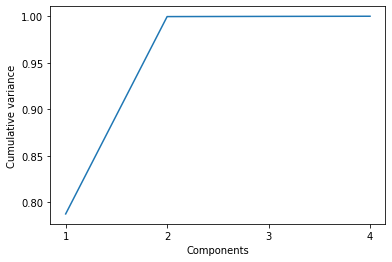

In [0]:
var = model_pca.explainedVariance.toArray()
plt.plot(np.cumsum(var))
plt.xticks(range(0,len(var)),[1,2,3,4])
plt.xlabel('Components')
plt.ylabel('Cumulative variance')
plt.savefig('pca.png')

Run pca with the optimal number of components

In [0]:
pca = PCA(k=2, inputCol="not_corr_features", outputCol="features")
model_pca = pca.fit(output)
transformed = model_pca.transform(output).select("features")

# Clustering

## K-means

In [0]:
ks = list(range(2,17))

In [0]:
silhouettes = []
costs_kmeans = []
for k in ks:
  kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
  kmeansModel = kmeans.fit(transformed)
  predictions = kmeansModel.transform(transformed)
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  silhouettes.append(silhouette)
  costs_kmeans.append(kmeansModel.computeCost(transformed))

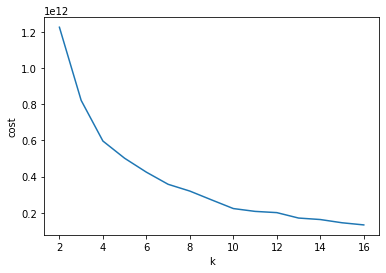

In [0]:
plt.plot(range(2,len(ks)+2),costs_kmeans)
plt.xlabel('k')
plt.ylabel('cost')
plt.savefig('cost_k_means.png')

The plot suggests that 6 is the correct number of clusters to select


In [0]:
kmeans = KMeans().setK(6).setSeed(1)
model_kmeans= kmeans.fit(transformed)   
results = model_kmeans.transform(transformed)  
centers = model_kmeans.clusterCenters()
pandasdf = results.toPandas()
pandasdf['class']=pdf['class']
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(results)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5710812578390112


In [0]:
pc1 = []
pc2 = []
for idx, row in pandasdf.iterrows():
    pc1.append(row[0][0])
    pc2.append(row[0][1])
pandasdf['pca1'] = pc1 
pandasdf['pca2'] = pc2
dfcenters = pd.DataFrame(centers, columns = ["x","y"])

### K-means visualization

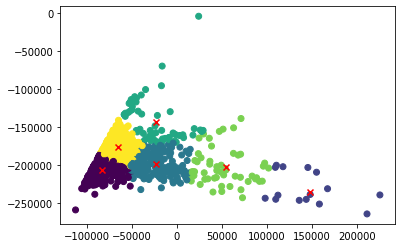

In [0]:
plt.scatter(pc1,pc2, c=pandasdf["prediction"])
plt.scatter(dfcenters["x"].values,dfcenters["y"].values, marker="x", color = "r")
plt.savefig('k_means_clusters.png')
plt.show()

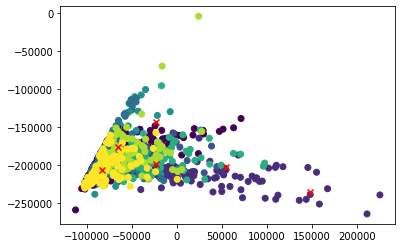

In [0]:
plt.scatter(pc1,pc2, c=pandasdf["class"])
plt.scatter(dfcenters["x"].values,dfcenters["y"].values, marker="x", color = "r")
plt.savefig('k_means_classes.png')
plt.show()

It is possible to recognize three classes that emerge in the upper left and right and in the low centre

## Bisecting k-means

In [0]:
costs = []
for k in ks:
  bkm = BisectingKMeans().setK(k).setSeed(1)
  model_bkm = bkm.fit(transformed)
  cost = model_bkm.computeCost(transformed)
  costs.append(cost)

In [0]:
plt.plot(range(2,len(ks)+2),costs)
plt.xlabel('k') 
plt.ylabel('cost')
plt.savefig('cost_bisecting.png')

The sharpest decrease ends when k  = 4 but untill k=8 it keeps on decreasing significantly, therefore k = 8 is the optimal value.

In [0]:
bkm = BisectingKMeans().setK(8).setSeed(1)
model_bkm = bkm.fit(transformed)
results = model_bkm.transform(transformed)  
centers = model_bkm.clusterCenters()
pandasdf = results.toPandas()
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(results)
print("Silhouette with squared euclidean distance = " + str(silhouette))

In [0]:
pc1 = []
pc2 = []
for idx, row in pandasdf.iterrows():
    pc1.append(row[0][0])
    pc2.append(row[0][1])
pandasdf['pca1'] = pc1 
pandasdf['pca2'] = pc2
pandasdf['class']=pdf['class']
dfcenters = pd.DataFrame(centers, columns = ["x","y"])

In [0]:
plt.scatter(pc1,pc2, c=pandasdf["prediction"])
plt.scatter(dfcenters["x"].values,dfcenters["y"].values, marker="x", color = "r")
plt.savefig('bisecting_clusters.png')
plt.show()

In [0]:
plt.scatter(pc1,pc2, c=pandasdf["class"])
plt.scatter(dfcenters["x"].values,dfcenters["y"].values, marker="x", color = "r")
plt.savefig('bisecting_classes.png')
plt.show()

It is possible to recognize three classes that emerge in the upper left and right and in the low centre.